In [1]:
#establishing environment
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import pickle
import scipy
from scipy.stats import pearsonr, ttest_rel, ttest_ind
from scipy import signal as sig
import matplotlib.patches as mpatches
import mat73
from scipy.io import loadmat, savemat
import mne
#conda install git+https://github.com/ieeg-portal/ieegpy.git # Install ieegpy toolbox directly from github
from ieeg.auth import Session
import random
from sklearn.cluster import KMeans
import os
os.chdir('/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/Interictal_Spike_Analysis/HUMAN/working_feat_extract_code/functions')
#os.chdir('E:/CNT/Interictal_Spike_Analysis/HUMAN/working_feat_extract_code/functions/')
from ied_functions import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
#data_directory = 'F:\CNT_data\pt_database'
data_directory = '/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/Patient/pt_database'
ptnames = ['HUP105','HUP106','HUP107','HUP111','HUP127','HUP128']

In [16]:
def avgroi_wave(idx_roich, based_vals):
    #per channel
    avg_waveforms2 = []
    for i in range(len(idx_roich)):
        ch = []
        for spikes2 in based_vals:
            spike_t = np.transpose(spikes2)
            ch.append((spike_t[idx_roich[i]]))
        avg_waveforms2.append(np.nanmean(ch, axis=0))
    return avg_waveforms2

def plot_avgroiwave(avg_waveform, roi,chnum):
    roi_ch = pd.DataFrame()
    for x in roi:
        roi_ch = roi_ch.append(brain_df[(brain_df['label'] == x)])

    roi_labels = np.array(roi_ch['label']) #converts DF to array
    fig, axs = plt.subplots(len(avg_waveform), 1, figsize=(7,15))
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.4)
    time = np.linspace(0,4,2001)
    for i in range(len(avg_waveform)):
        axs[i].plot(time, avg_waveform[i], 'k') #plot nerve data - unfiltered
        axs[i].set_ylabel("Voltage (millivolts)")
        axs[i].set_xlabel("Time (s)")
        axs[i].set_title("Average Waveform for Channel {} in {}".format(int(chnum[i]),roi_labels[i]))
    return fig

def downsample_to_2001(vals):
    """
    Use only on the per sample level (samples x channels), in our stuff it works on values[0]
    """
    downsamp_vals = vals[::2]
    biglen = len(downsamp_vals)
    diff = int((biglen - 2001)/2)
    new_sample = downsamp_vals[diff:-diff]

    return new_sample

def totalavg_roiwave(idx_roich, based_vals):
    #total per ROI
    avg_waveform = []

    waveform = []
    all_waveforms = []
    for i in range(len(idx_roich)):
        for spikes2 in based_vals:
            if len(spikes2) > 2001:
                spike_down = downsample_to_2001(spikes2)
            else:
                spike_down = spikes2
            spike_t = np.transpose(spike_down)
            waveform.append((spike_t[idx_roich[i]]))
        all_waveforms.append((waveform))

    concat = [x[0] for x in all_waveforms]
    avg_waveform = np.nanmean(concat,axis=0)
    abs_avg_waveform = np.nanmean(np.abs(concat), axis=0)

    return avg_waveform, abs_avg_waveform, concat

def plot_avgroiwave(avg_waveform, title_label):
    time = np.linspace(0,4,2001)
    fig = plt.figure(figsize = (6,6))
    plt.plot(time,avg_waveform,'k')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (millivolts)')
    plt.title('Average Waveform for {}'.format(title_label))
    plt.tight_layout()
    plt.show()
    return fig


def plot_avgROIwave_multipt(ptnames, roi, title):
    roiLmesi_vals = []
    avgwaves = []
    abs_avgwaves = []
    count = 0
    for pt in ptnames:
        print(pt)
        spike, brain_df, ids = load_ptall(pt,data_directory)
        vals, chnum, idxch = value_basis(spike, brain_df, roi)    
        if vals == 0:
            count += 1
            continue
        avg_waveform,abs_avg_waveform,indiv_vals = totalavg_roiwave(idxch, vals)
        avgwaves.append(avg_waveform)
        roiLmesi_vals.append(indiv_vals)
        abs_avgwaves.append(abs_avg_waveform)

    all_chs = [x[0] for x in roiLmesi_vals]
    total_avg = np.nanmean(all_chs, axis =0)
    abs_total_avg = np.nanmean(np.abs(all_chs), axis=0)

    samps = len(ptnames) - count
    if samps == 0:
        print('no matches!')
    time = np.linspace(0,4,len(total_avg))
    #abs = False
    fig = plt.figure(figsize=(10,10))
    for vals in avgwaves:
        plt.plot(time, vals, color='grey', label='patient average')
    plt.plot(time, total_avg,'r',label ='cohort average')
    plt.title('{} Average Spike in {} Patients'.format(title, samps))
    plt.xlabel('time (s)')
    plt.ylabel('Voltage (mV)')
    plt.legend()
    plt.show()
    
    #abs = True
    fig2 = plt.figure(figsize=(10,10))
    for vals in abs_avgwaves:
        plt.plot(time, vals, color='grey', label='patient average')
    plt.plot(time, abs_total_avg,'r',label ='cohort average')
    plt.title('[ABS] {} Average Spike in {} Patients'.format(title, samps))
    plt.xlabel('time (s)')
    plt.ylabel('Voltage (mV)')
    plt.legend()
    plt.show()
    return fig, fig2, total_avg, abs_total_avg, all_chs

HUP105
HUP106
HUP107
HUP111
HUP127
HUP128


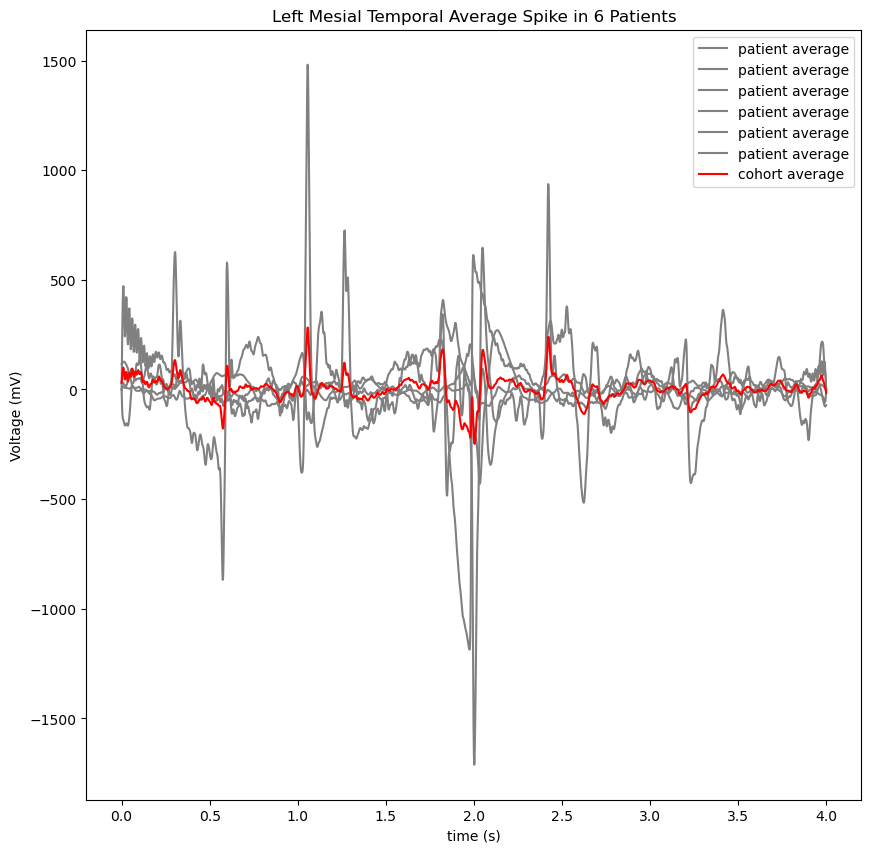

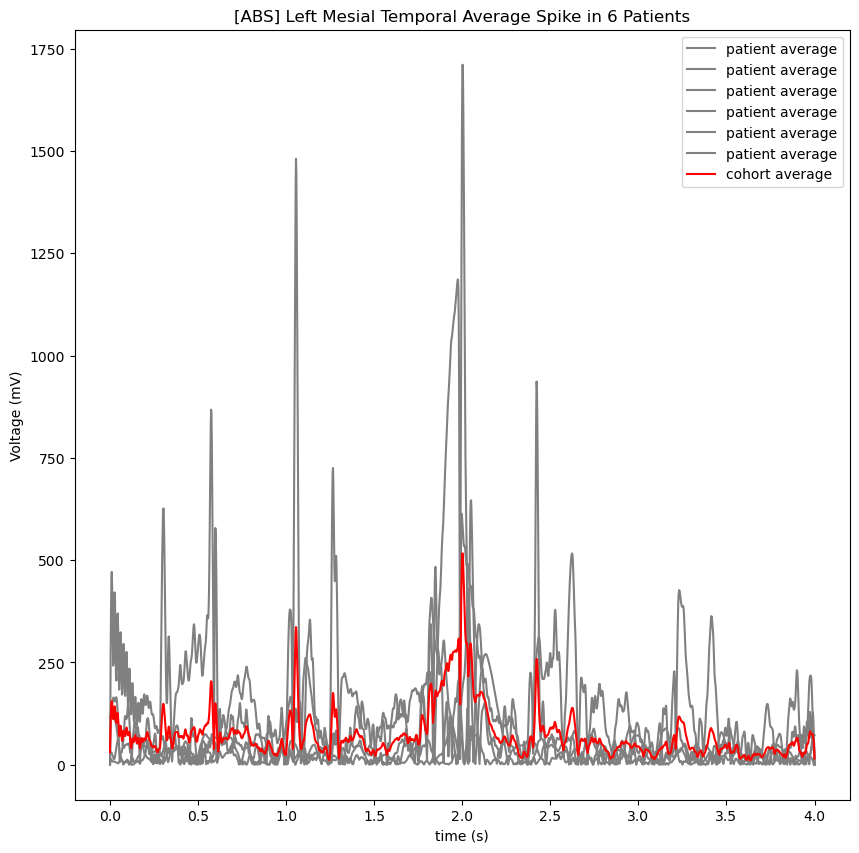

In [4]:
roiL_mesial = [' left entorhinal ', ' left parahippocampal ' , ' left hippocampus ', ' left amygdala ', ' left perirhinal ']
fig, fig_abs, total_avg, abs_total_avg, all_chs = plot_avgROIwave_multipt(ptnames, roiL_mesial, title='Left Mesial Temporal')
save = 'L_mesial'
#fig.savefig("/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/Interictal_Spike_Analysis/HUMAN/working_feat_extract_code/spike figures/ALL_pt/norm/{}_norm".format(save)) #save as jpg
#fig_abs.savefig("/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/Interictal_Spike_Analysis/HUMAN/working_feat_extract_code/spike figures/ALL_pt/abs/{}_abs".format(save)) #save as jpg


HUP105
HUP106
HUP107
HUP111
HUP127
HUP128


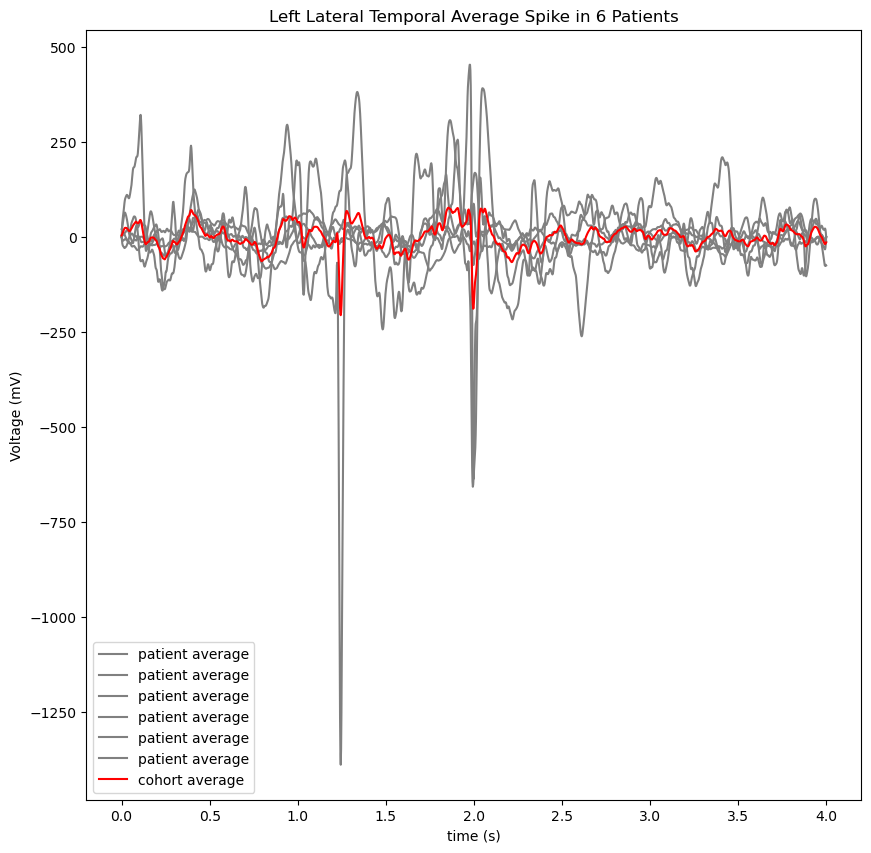

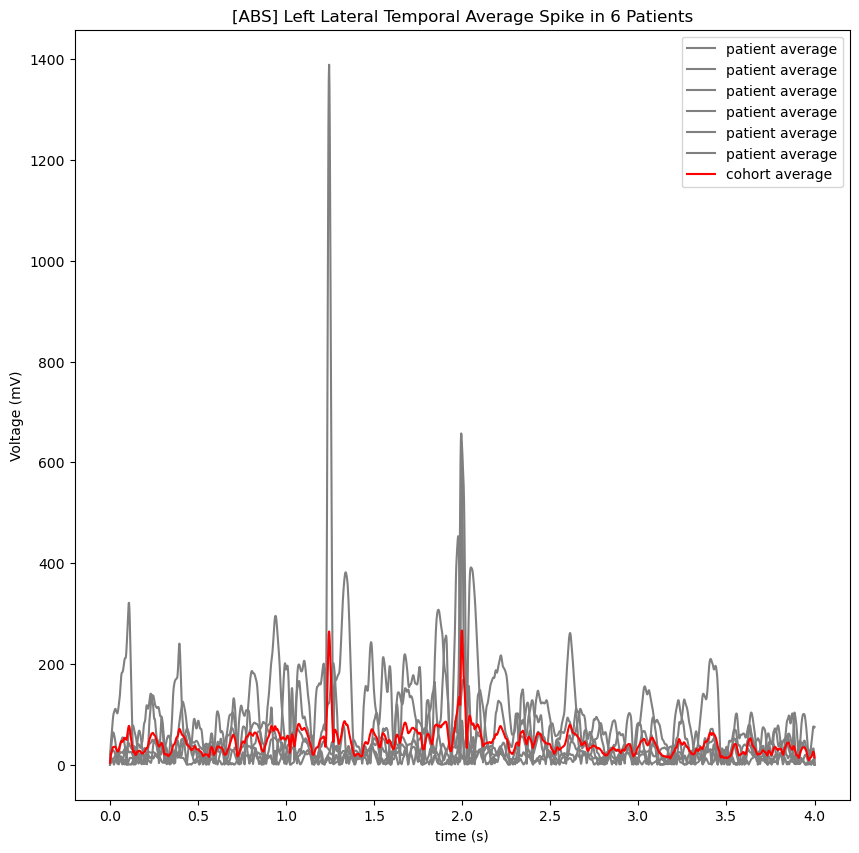

In [5]:
roiL_lateral = [' left inferior temporal ', ' left superior temporal ', ' left middle temporal ', ' left fusiform ']
fig, fig_abs, total_avg, abs_total_avg, all_chs = plot_avgROIwave_multipt(ptnames, roiL_lateral, title='Left Lateral Temporal')

save = 'L_lateral'
#fig.savefig("/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/Interictal_Spike_Analysis/HUMAN/working_feat_extract_code/spike figures/ALL_pt/norm/{}_norm".format(save)) #save as jpg
#fig_abs.savefig("/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/Interictal_Spike_Analysis/HUMAN/working_feat_extract_code/spike figures/ALL_pt/abs/{}_abs".format(save)) #save as jpg

HUP105
HUP106
NO MATCHES
HUP107
HUP111
NO MATCHES
HUP127
HUP128


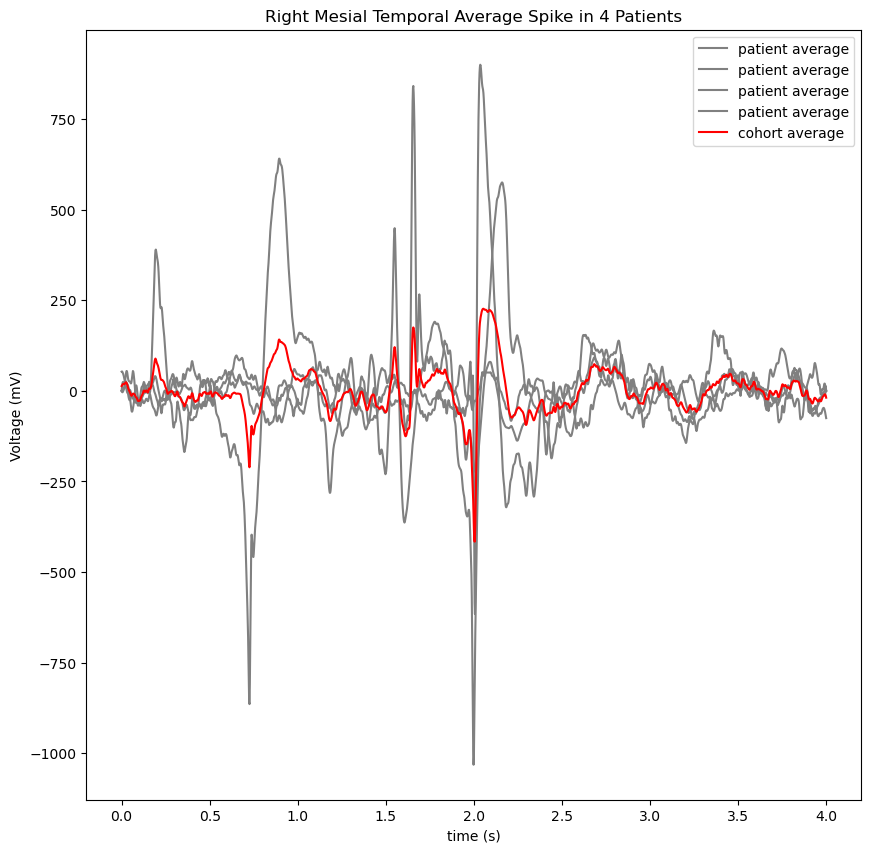

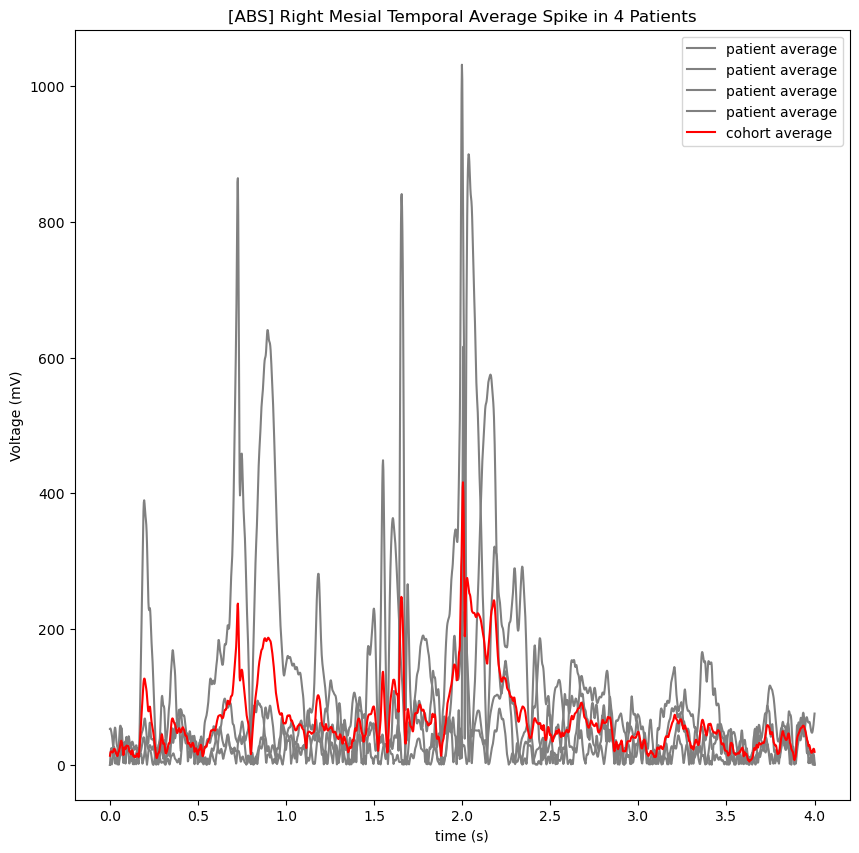

In [18]:
roiR_mesial = [' right entorhinal ', ' right parahippocampal ', ' right hippocampus ', ' right amygdala ', ' right perirhinal ']

fig, fig_abs, total_avg, abs_total_avg, all_chs = plot_avgROIwave_multipt(ptnames, roiR_mesial, title='Right Mesial Temporal')
save = 'R_mesial'
#fig.savefig("/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/Interictal_Spike_Analysis/HUMAN/working_feat_extract_code/spike figures/ALL_pt/norm/{}_norm".format(save)) #save as jpg
#fig_abs.savefig("/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/Interictal_Spike_Analysis/HUMAN/working_feat_extract_code/spike figures/ALL_pt/abs/{}_abs".format(save)) #save as jpg

HUP105
HUP106
HUP107
HUP111
HUP127
HUP128


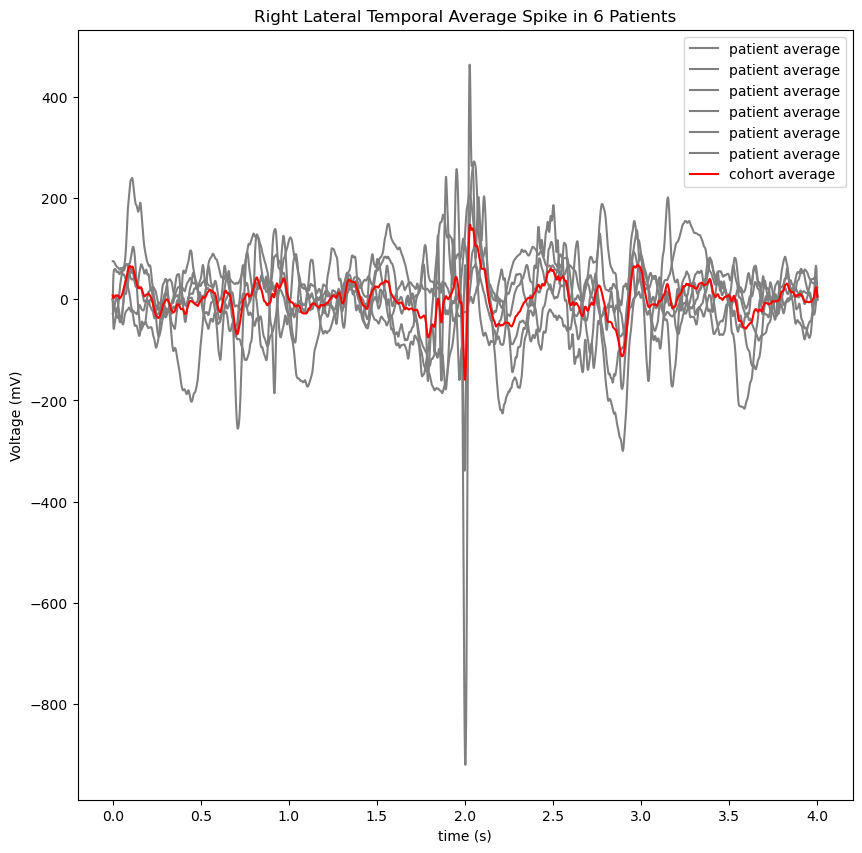

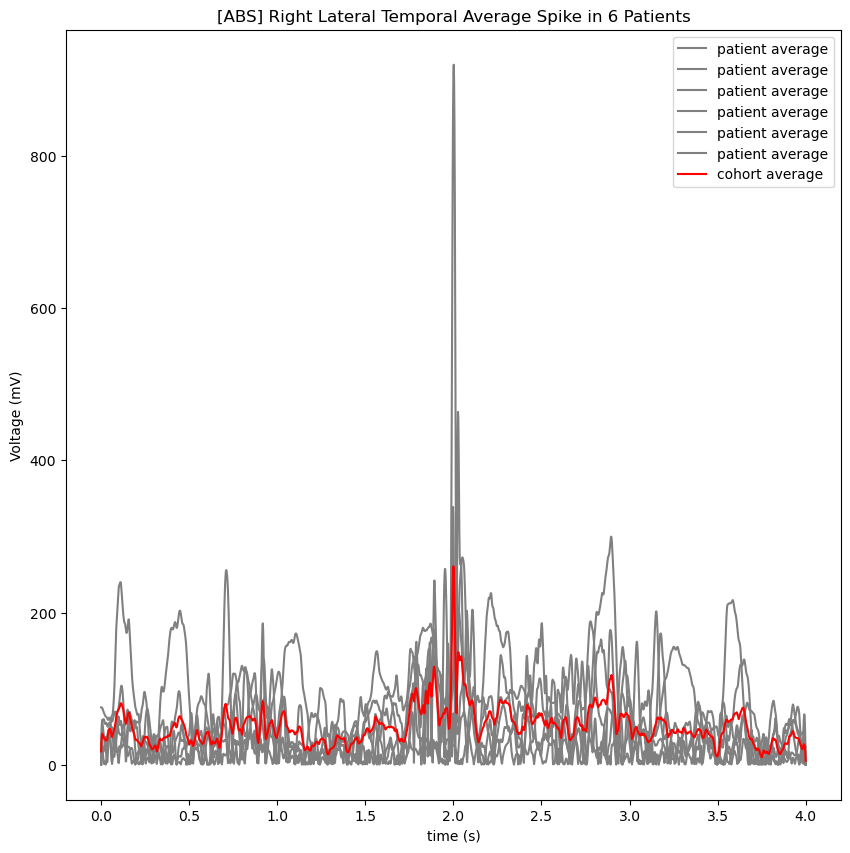

In [17]:
roiR_lateral = [' right inferior temporal ', ' right superior temporal ', ' right middle temporal ', ' right fusiform ']

fig, fig_abs, total_avg, abs_total_avg, all_chs = plot_avgROIwave_multipt(ptnames, roiR_lateral, title='Right Lateral Temporal')
save = 'R_lateral'
#fig.savefig("/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/Interictal_Spike_Analysis/HUMAN/working_feat_extract_code/spike figures/ALL_pt/norm/{}_norm".format(save)) #save as jpg
#fig_abs.savefig("/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/Interictal_Spike_Analysis/HUMAN/working_feat_extract_code/spike figures/ALL_pt/abs/{}_abs".format(save)) #save as jpg